In [6]:
import networkx as nx

from braket.ahs.atom_arrangement import AtomArrangement
from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation
from braket.aws import AwsDevice

from braket.timings.time_series import TimeSeries
from braket.ahs.driving_field import DrivingField
from braket.ahs.field import Field
from braket.devices import LocalSimulator
from braket.ahs.hamiltonian import Hamiltonian

import matplotlib.pyplot as plt
import time
import numpy as np


In [86]:
# constants
atoms_w = 4
atoms_l = 4
blockade_radius = 7.5
np.random.seed(99)

In [87]:
def generate_unit_disk(atoms_l: int, atoms_w: int, scale=4.0*1e-6, dropout=0.45):
    atom_list = []
    edge_dict = {}
    atom_to_edge = {}
    for ii in range(atoms_l):
        for jj in range(atoms_w):
            atom_list.append((ii*scale, jj*scale))
            atom_to_edge[(ii*scale, jj*scale)] = ii*atoms_w + jj
            edge_dict[ii*atoms_w + jj] = []
            if jj < atoms_w - 1:
                edge_dict[ii*atoms_w + jj].append(ii*atoms_w + jj + 1)
            if ii < atoms_l - 1:
                edge_dict[ii*atoms_w + jj].append((ii+1)*atoms_w + jj)
            if ii < atoms_l - 1 and jj < atoms_w - 1:
                # nearest neighbor
                edge_dict[ii*atoms_w + jj].append((ii+1)*atoms_w + jj + 1)
            if jj > 0 and ii < atoms_l - 1:
                # nearest neighbor
                edge_dict[ii*atoms_w + jj].append((ii+1)*atoms_w + jj - 1)

    graph = nx.from_dict_of_lists(edge_dict)
    
    # dropout
    new_len = int(np.round(len(atom_list) * (1 - dropout)))
    atom_arr = np.empty(len(atom_list), dtype=object)
    atom_arr[:] = atom_list
    remaining_atom_list = np.random.choice(atom_arr, new_len, replace=False)
    
    dropped_edge_dict = {}
    atoms = AtomArrangement()
    for atom in remaining_atom_list:
        atoms.add(atom)
    graph.remove_nodes_from([atom_to_edge[atom] for atom in  set(atom_list) - set(list(remaining_atom_list))])

    return atoms, graph

In [88]:
atoms, graph = generate_unit_disk(atoms_l, atoms_w)

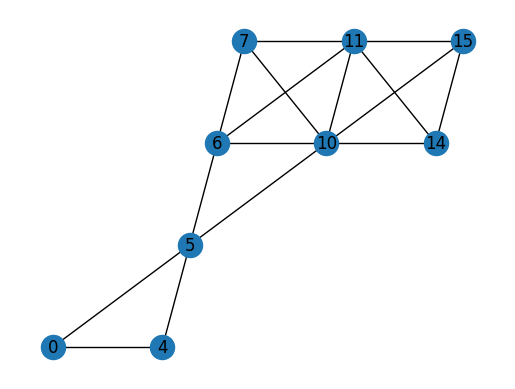

In [89]:
fig, ax = plt.subplots()
pos = {ii: (ii/atoms_w,ii%atoms_w) for ii in graph.nodes()}
nx.draw(graph, pos=pos, ax=ax, with_labels=True)
plt.show()

In [90]:
def loss_piecewise_linear(atoms: AtomArrangement, T_flat: float, T_max: float, T_rise: float, Omega_max: float, Delta_max: float, shots=5000):
  
    Delta_start = -Delta_max
    Delta_end = Delta_max

    time_points = [ 0.0, T_flat, T_flat + T_rise, T_max - T_flat - T_rise, T_max - T_flat, T_max ]

    Deltas = TimeSeries()
    Deltas.put(time_points[0], Delta_start)
    Deltas.put(time_points[1], Delta_start)
    Deltas.put(time_points[4], Delta_end)
    Deltas.put(time_points[5], Delta_end)

    Omegas = TimeSeries()
    Omegas.put(time_points[0], 0.0)
    Omegas.put(time_points[1], 0.0)
    Omegas.put(time_points[2], Omega_max)
    Omegas.put(time_points[3], Omega_max)
    Omegas.put(time_points[4], 0.0)
    Omegas.put(time_points[5], 0.0)
    

    Phi = TimeSeries()
    Phi.put(time_points[0], 0.0)
    Phi.put(time_points[5], 0.0)

    H = DrivingField(amplitude=Omegas, phase=Phi, detuning=Deltas)

    program = AnalogHamiltonianSimulation(hamiltonian=H, register=atoms)
    device = LocalSimulator("braket_ahs")

    results = device.run(program, shots=shots, steps=100).result()

    r_counts = []

    states = ['e', 'r', 'g']
    for shot in results.measurements:
        pre = shot.pre_sequence
        post = shot.post_sequence
        state_idx = np.array(pre) * (1 + np.array(post))
        state_labels = [states[s_idx] for s_idx in state_idx]
        r_count = np.count_nonzero([sl == 'r' for sl in state_labels]) / len(atoms)
        r_counts.append(r_count)

    density_sum = np.mean(r_counts)
    density_std = np.std(r_counts)

    return density_sum, density_std, results, Deltas

In [91]:
from collections import Counter

Omega_max = 4*2*np.pi*1e6
Delta_max = 11*2*np.pi*1e6

T_flat = 0.1*1e-6
T_max = 0.6*1e-6
T_rise = 0.05*1e-6

start = time.time()
initial_rydberg_density, initial_density_std, initial_registers, initial_Deltas = loss_piecewise_linear(atoms, T_flat, T_max, T_rise, Omega_max, Delta_max)
print(f"Initial density: {initial_rydberg_density}, Standard deviation: {initial_density_std}")
stop = time.time()
print(f"Time to run AHS with local simulator: {stop-start}")


Initial density: 0.31595555555555555, Standard deviation: 0.044213153732378815
Time to run AHS with local simulator: 2.5619091987609863


Independent set of 0-th most likely outcome


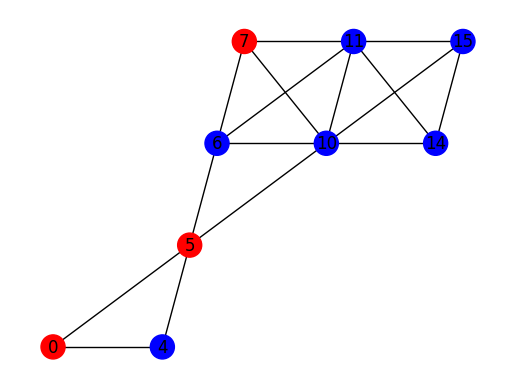

Independent set of 1-th most likely outcome


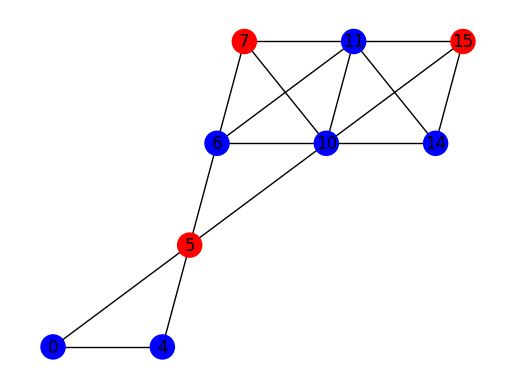

Independent set of 2-th most likely outcome


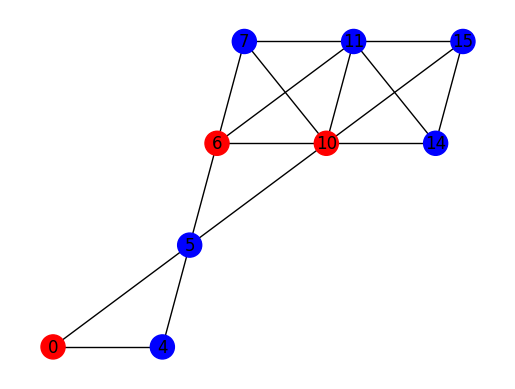

Independent set of 3-th most likely outcome


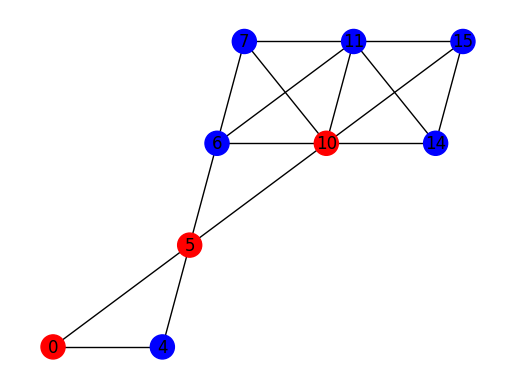

Independent set of 4-th most likely outcome


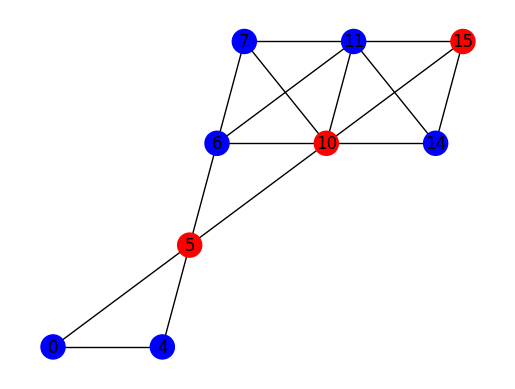

In [92]:
states = ['e', 'r', 'g']
state_labels = []
for shot in initial_registers.measurements:
    pre = shot.pre_sequence
    post = shot.post_sequence
    state_idx = np.array(pre) * (1 + np.array(post))
    state_labels.append("".join([states[s_idx] for s_idx in state_idx]))

occurence_count = Counter(state_labels)

most_frequent_regs = occurence_count.most_common(5)
for ii in range(len(most_frequent_regs)):
    fig, ax = plt.subplots()
    vert_colors = ['red' if (most_frequent_regs[ii][0][i] == 'r') else 'blue' for i in range(len(most_frequent_regs[ii][0]))]
    print(f'Independent set of {ii}-th most likely outcome')
    nx.draw(graph, pos = {ii: (ii/atoms_w,ii%atoms_w) for ii in graph.nodes()}, ax=ax, with_labels=True, node_color=vert_colors)
    plt.show()

In [31]:
# Mean vs Delta
delta_values = np.linspace(-15 * 2 * np.pi * 1e6, 15 * 2 * np.pi * 1e6, 100)
mean_densities = []

for delta in delta_values:
    mean_density, _, _, _ = loss_piecewise_linear(atoms, T_flat, T_max, T_rise, Delta_max, Omega_max)
    mean_densities.append(mean_density)

window_size = 5
mean_densities_smooth = np.convolve(mean_densities, np.ones(window_size) / window_size, mode='valid')

plt.figure(figsize=(10, 6))
plt.plot(delta_values[:len(mean_densities_smooth)], mean_densities_smooth, marker='o', linestyle='-', color='b')
plt.xlabel('Delta (Hz)')
plt.ylabel('Mean Density')
plt.title('Distribution of Mean Density vs. Delta')
plt.grid(True)
plt.show()

KeyboardInterrupt: 

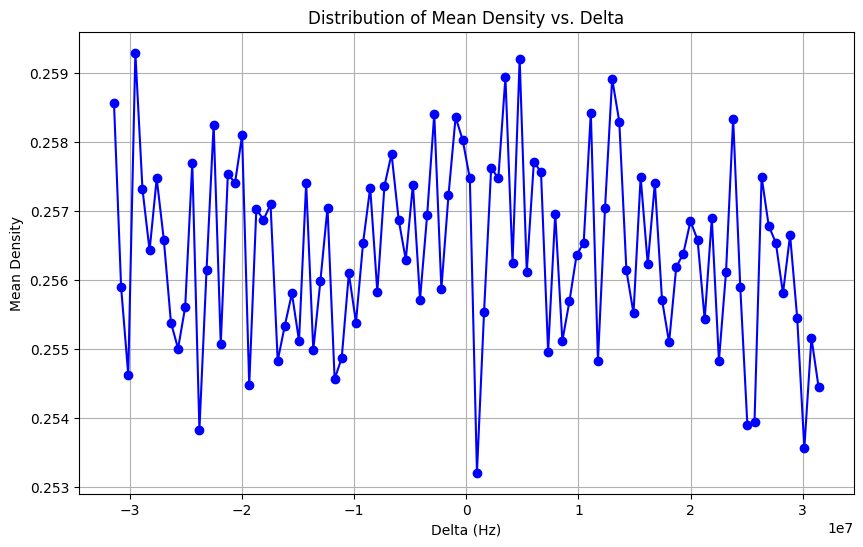

In [34]:
# Mean vs Delta
delta_values = np.linspace(-5 * 2 * np.pi * 1e6, 5 * 2 * np.pi * 1e6, 100)
mean_densities = []

x0 = [0.1, 0.1, 0.1]

for delta in delta_values:
    x0[0] = delta / (11 * 2 * np.pi * 1e6)
    x0[1] = delta / (11 * 2 * np.pi * 1e6)
    x0[2] = delta / (11 * 2 * np.pi * 1e6)
    mean_density, _, _, _ = loss_piecewise_linear(atoms, T_flat, T_max, T_rise, Delta_max, Omega_max)
    mean_densities.append(mean_density)

plt.figure(figsize=(10, 6))
plt.plot(delta_values, mean_densities, marker='o', linestyle='-', color='b')
plt.xlabel('Delta (Hz)')
plt.ylabel('Mean Density')
plt.title('Distribution of Mean Density vs. Delta')
plt.grid(True)
plt.show()

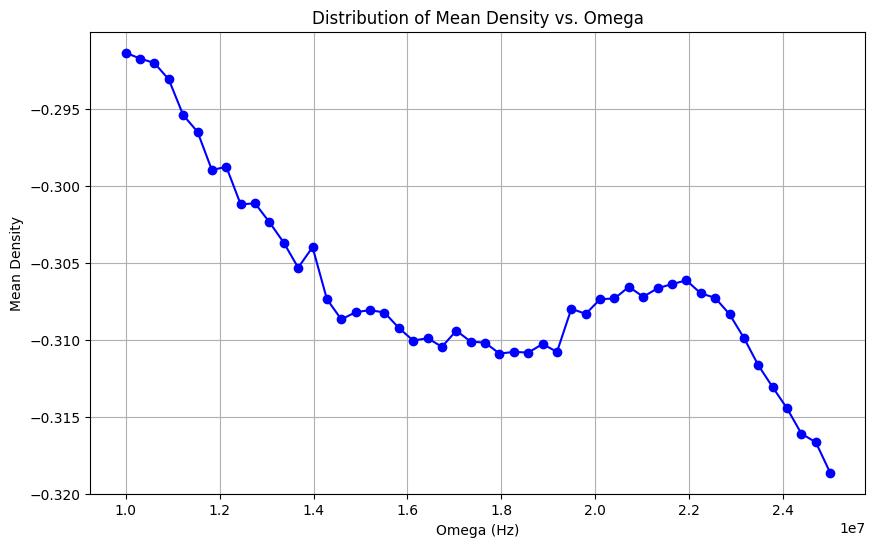

In [33]:
# Mean vs Omega
omega_values = np.linspace(1e7, 2.5e7, 50)
mean_densities = []

x0 = [0.1, 0.8, 0.1]

for omega in omega_values:
    x0[0] = omega / (4 * 2 * np.pi * 1e6)
    x0[1] = omega / (4 * 2 * np.pi * 1e6)
    x0[2] = omega / (4 * 2 * np.pi * 1e6)
    mean_density, _, _, _ = loss_piecewise_linear(atoms, x0)
    mean_densities.append(mean_density)

plt.figure(figsize=(10, 6))
plt.plot(omega_values, mean_densities, marker='o', linestyle='-', color='b')
plt.xlabel('Omega (Hz)')
plt.ylabel('Mean Density')
plt.title('Distribution of Mean Density vs. Omega')
plt.grid(True)
plt.show()


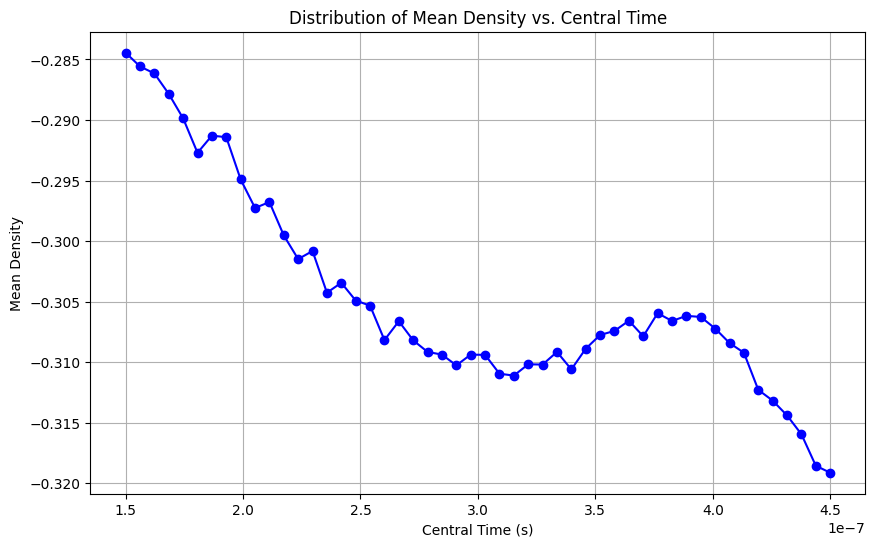

In [29]:
# Time vs. Mean
central_times = np.linspace(0.15e-6, 0.45e-6, 50)
mean_densities = []

x0 = [0.1, 0.8, 0.1]

for central_time in central_times:
    x0[0] = central_time / (0.45e-6)
    x0[1] = central_time / (0.45e-6)
    x0[2] = central_time / (0.45e-6)
    mean_density, _, _, _ = loss_piecewise_linear(atoms, x0)
    mean_densities.append(mean_density)

plt.figure(figsize=(10, 6))
plt.plot(central_times, mean_densities, marker='o', linestyle='-', color='b')
plt.xlabel('Central Time (s)')
plt.ylabel('Mean Density')
plt.title('Distribution of Mean Density vs. Central Time')
plt.grid(True)
plt.show()

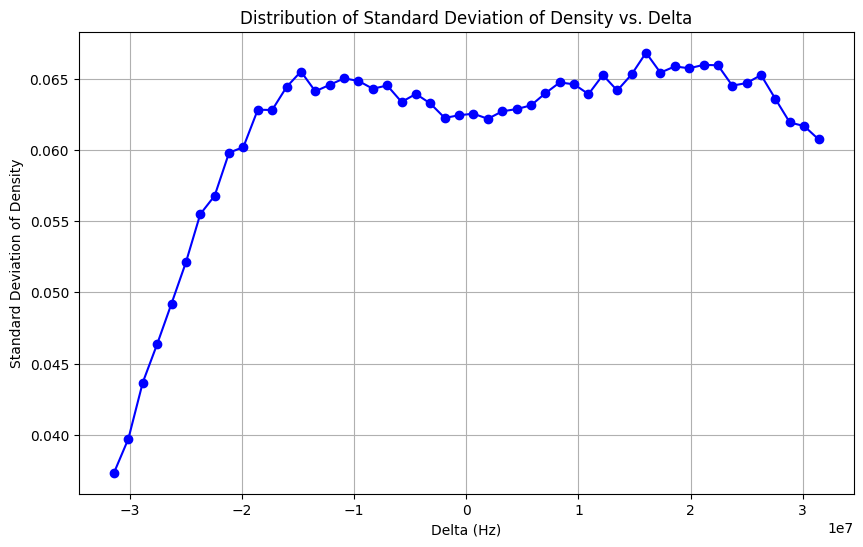

In [30]:
# Standard Deviation vs Delta
delta_values = np.linspace(-5 * 2 * np.pi * 1e6, 5 * 2 * np.pi * 1e6, 50)
density_stds = []

x0 = [0.1, 0.8, 0.1]

for delta in delta_values:
    x0[0] = delta / (11 * 2 * np.pi * 1e6)
    x0[1] = delta / (11 * 2 * np.pi * 1e6)
    x0[2] = delta / (11 * 2 * np.pi * 1e6)
    _, density_std, _, _ = loss_piecewise_linear(atoms, x0)
    density_stds.append(density_std)

plt.figure(figsize=(10, 6))
plt.plot(delta_values, density_stds, marker='o', linestyle='-', color='b')
plt.xlabel('Delta (Hz)')
plt.ylabel('Standard Deviation of Density')
plt.title('Distribution of Standard Deviation of Density vs. Delta')
plt.grid(True)
plt.show()

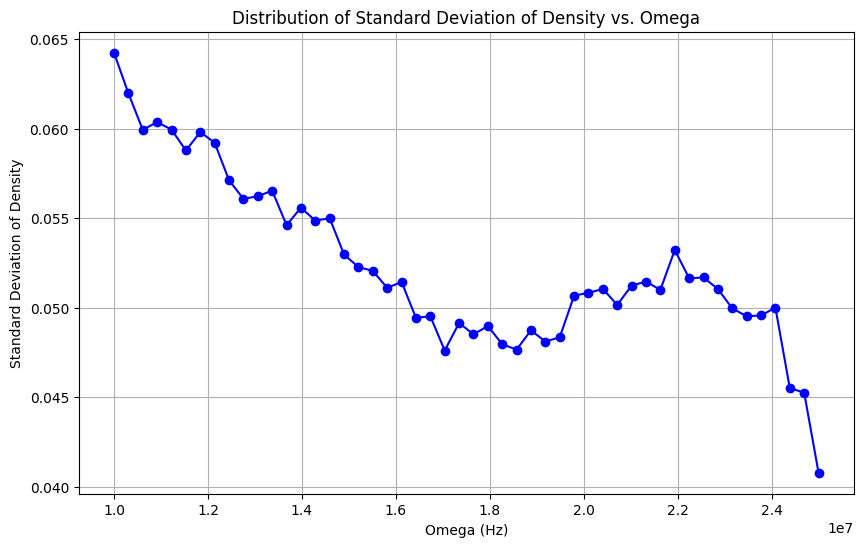

In [34]:
# Standard Deviation vs Omega
omega_values = np.linspace(1e7, 2.5e7, 50)
density_stds = []

x0 = [0.1, 0.8, 0.1]

for omega in omega_values:
    x0[0] = omega / (4 * 2 * np.pi * 1e6)
    x0[1] = omega / (4 * 2 * np.pi * 1e6)
    x0[2] = omega / (4 * 2 * np.pi * 1e6)
    _, density_std, _, _ = loss_piecewise_linear(atoms, x0)
    density_stds.append(density_std)

plt.figure(figsize=(10, 6))
plt.plot(omega_values, density_stds, marker='o', linestyle='-', color='b')
plt.xlabel('Omega (Hz)')
plt.ylabel('Standard Deviation of Density')
plt.title('Distribution of Standard Deviation of Density vs. Omega')
plt.grid(True)
plt.show()

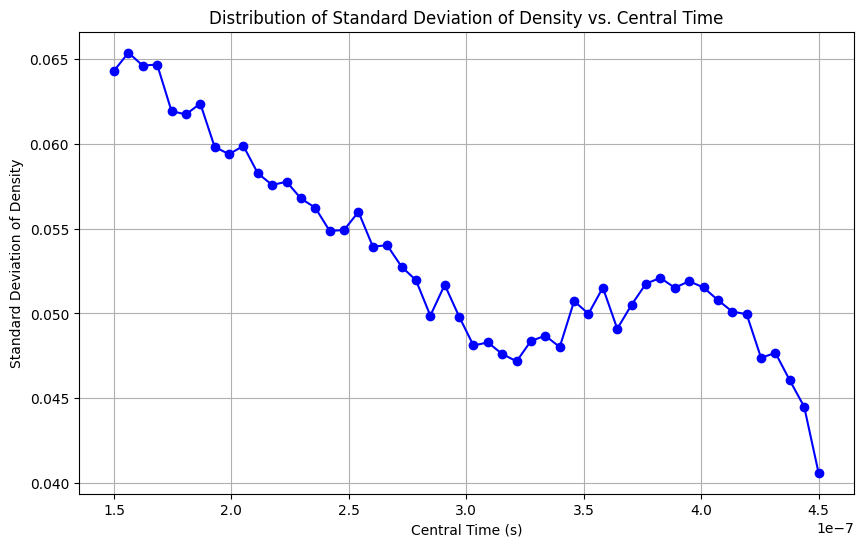

In [32]:
# Standard Deviation vs Central Time
central_times = np.linspace(0.15e-6, 0.45e-6, 50)
density_stds = []

x0 = [0.1, 0.8, 0.1]

for central_time in central_times:
    x0[0] = central_time / (0.45e-6)
    x0[1] = central_time / (0.45e-6)
    x0[2] = central_time / (0.45e-6)
    _, density_std, _, _ = loss_piecewise_linear(atoms, x0)
    density_stds.append(density_std)

plt.figure(figsize=(10, 6))
plt.plot(central_times, density_stds, marker='o', linestyle='-', color='b')
plt.xlabel('Central Time (s)')
plt.ylabel('Standard Deviation of Density')
plt.title('Distribution of Standard Deviation of Density vs. Central Time')
plt.grid(True)
plt.show()